In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
from math import *

class Simulation(object):
    """The numerical simulation"""
    def __setattr__(self,name,value):
        object.__setattr__(self, name, value)
        #used to allow attribute write access by other methods
    
    def __init__(self,parent):
        self.parent = parent #for reference to gui appframe
        #stage parameter lists
        self.burntime = ['']
        self.thrust0 = ['']
        self.Isp0 = ['']
        self.m0 = ['']
        self.fuelfraction = ['']
        self.fuelmass = ['']
        self.dMdt = ['']
        #results dict
        self.data = {'Time':[0],'Height':[0],'Mass':[0],'Velocity':[0],'Thrust':[0],'Drag':[0],'Gamma':[pi/2],'Range':[0]}
    
    def integrate(self,trajectory):
        t = 0.0     # time
        v = 0       # initial v
        h = 0.001   # initial h must be small but non-zero
        psi = 0     # range angle: range = psi * Rearth
        rho = 0.0   # air density at current altitude
        p_height = 0.0 # air pressure at current altitude
        gamma = self.to_radians(90) #launch angle, from horizontal
        
        
        #print "Start Simulation"
        # ref for printing results in GUI mode
        try:
            app = wx.GetTopLevelParent(self.parent)
        except NameError:
            pass
        self.trajectory = trajectory #make ref for eta function
        ##### SET INTEGRATION PARAMETERS
        tEND = 20000        #timeout value
        dtprint = 1         #time interval between printing output
        Htrans = 20000  #height [m] at which transition from laminar to turbulent heating occurs
        deltaend = .1       #time increment used for integration
        deltatinit = .01    #time increment for t < tinit + 1 sec
        mtot = 0.0
        burntimetot = 0.0
        tinit = burntimetot + 1 # integrate more carefully during burn
        #####
        apogee = 0.0
        Thrust = 0.0
        drag = 0.0
        ##### SET CONSTANTS
        Rearth = 6370000 #[m]
        g0 = 9.8066 #[m/s^2]
        #
        ##### INITIALIZE ROCKET MODEL
        
        for i in range(1,self.numstages+1):
            mtot += self.m0[i] #sum total mass
            self.burntime.append(self.Isp0[i]*9.81*self.fuelmass[i]/self.thrust0[i])
            burntimetot += self.burntime[i] #sum total burn time
        mtot += self.payload
        
        area_missile = (self.missilediam/2)**2 * pi #[m^2]
        area_rv = self.rvdiam/2**2 * pi #[m^2]
        #####
        
        ##### INTEGRATE
        #   
        #Initialize variables
        deltat = deltatinit
        flagdeltat = True
        m = mtot
        #
        dMdt0 = self.dMdt[1]
        tprint = dtprint #tprint is time at which printing of output will next occur
        flag = True # controls printing parameters at burnout of stages
        tlimit = self.burntime[1] # ditto
        nstage = 1  # used at burnout of stages
        gamma_half = gamma # angle of missile or RV w/ local horizon
        
        #set burnout angle to optimum for MET
        #uses Wheelon's form of the equations
        opt_burnout_angle = pi/2 - .25*(self.est_range/Rearth + pi)
        #use this optimum burnout angle to linearize turn angle, from horizontal

        
        #Integrate
        while t < tEND and h > 0: # big loop
            #save data to Results dict
            self.data['Time'].append(t) #in tenths seconds
            self.data['Height'].append(h) #in meters
            self.data['Mass'].append(m) #in kg
            self.data['Velocity'].append(v) #in meters/second
            self.data['Thrust'].append(Thrust) #in in kgf
            self.data['Drag'].append(drag) #in N
            self.data['Gamma'].append(gamma) #in degrees from horizontal
            self.data['Range'].append(Rearth*psi) #in meters
            
            if (t + deltat/5) >= tinit and flagdeltat == True:
                deltat = deltaend
                flagdeltat = False
            
            #
            # save old values
            psi_old = psi
            h_old = h
            gamma_old = gamma
            v_old = v
            m_old = m
            t_old = t
            #
            if (t + deltat/5) <= burntimetot: 
                m_half = m_old - (dMdt0 * deltat/2) #burn fuel
                area = area_missile
            else:
                area = area_rv
            #calculate drag
            rho = self.density(h)
            cd = self.Cdrag(v_old,h)
            drag = cd*area*rho*(v_old**2)/2
            
            # calculate thrust as function of altitude
            #NEW EQUATIONS, from Charles Vick
            h_vacuum = 160934 #~100 miles
            Thrust_ideal = self.Isp0[nstage]*self.dMdt[nstage]*9.81
            if (t + deltat/5) > burntimetot:
                Thrust_pct_increase = 0
                #out of fuel, no thrust
            elif h < h_vacuum:
                h_norm = h / h_vacuum
                Thrust_pct_increase = -.4339*(h_norm)**3+.6233*(h_norm)**2-.01*(h_norm)+1.004
                #3rd order polynomial line fit from Saturn-V data on thrust vs. height
                
            elif h > h_vacuum and nstage == 1:
                Thrust_pct_increase = 1.19
                Thrust = Thrust_ideal*Thrust_pct_increase
            elif nstage > 1:
                Thrust_pct_increase = 1
                #assuming that stage Isp is correct for vacuum
            Thrust = Thrust_ideal*Thrust_pct_increase
            Force = Thrust - drag
            #note that Force will be negative during reentry
            
            #OLD EQUATIONS, from David Wright
            #requires us to know nozzle area, which we don't
            #p0 = self.pressure(0)
            #p_height = self.pressure(h)
            #self.nozarea = .3 #[m^2] for TD-1
            #if (t + deltat/5) > burntimetot:
            #   Thrust = 0.0
            #elif nstage == 1:  
            #   Thrust = self.Isp0[1]*self.dMdt[1]*9.81 + self.nozarea*(p0-p_height)
            #elif nstage > 1:
            #   Thrust = self.Isp0[nstage]*self.dMdt[nstage]*9.81
    
                
            #
            g = g0*Rearth**2/(h+Rearth)**2 #calculate grav accel at height
            
            ETA_old = self.eta(h_old,t_old)
            #
            # Integration is variant of Runge-Kutta-2.
            # 1- Calculate values at midpoint, t = t_old + deltat/2
            #
            t_half = t_old + deltat/2
            d_psi = (v_old * cos(gamma_old)/(Rearth + h_old)) * deltat/2
            psi_half = psi_old + d_psi
            h_half = h_old + v_old*sin(gamma_old)*deltat/2
            #
            # calculate gamma
            
            vertical_flight_period = 5
            if t < vertical_flight_period:
                #force gamma to be constant early in flight
                dgamma = 0.0
            elif (t >= vertical_flight_period) and (t <= burntimetot):
                dgamma = ((opt_burnout_angle - pi/2)/(burntimetot - vertical_flight_period))
            else:
                dgamma = d_psi/(deltat/2) + Force*sin(ETA_old)/(v_old * m_old) - (g*cos(gamma_old)/v_old)
            
            #integrate it
            gamma_half = gamma_old + dgamma*deltat/2
            
            # calculate dv
            dv = (Force/m_old)*cos(ETA_old) - g*sin(gamma_old)
            
            v_half = v_old + dv*deltat/2
            #
            #
            # 2- Use derivatives at midpoint to calculate values at t + deltat
            ETA_half = self.eta(h_half,t_half)
            # Increment time
            t += deltat
            #
            d_psi_half = (v_half*cos(gamma_half))/(Rearth+h_half) * deltat
            psi = psi_old + d_psi_half
            h = h_old + v_half*sin(gamma_half)*deltat
            if h > h_old:
                apogee = h
                v_apogee = v

            vertical_flight_period = 5
            if t <= vertical_flight_period:
                dgamma_half = 0.0
            elif (t > vertical_flight_period) and (t <= burntimetot):
                dgamma_half = ((opt_burnout_angle - pi/2)/(burntimetot - vertical_flight_period))
            else:
                #use Wright's equation, hopefully not too disjoint with previous
                dgamma_half = d_psi_half/(deltat) + (Force/(v_half*m_half))*sin(ETA_half) - (g*cos(gamma_half)/v_half)
                
            gamma = gamma_old + dgamma_half*deltat

            if (t + deltat/5) <= burntimetot:
                m = m_old - dMdt0 * deltat
                #burn fuel mass 
    
            dv_half = (Force/m_half)*cos(ETA_half) - g*sin(gamma_half)
            v = v_old + dv_half*deltat
                        
            #Print data at stage burnout
            if (t + deltat / 5) > tlimit and flag == True:
                if __name__ == "__main__":
                    #Simple text printout
                    print("Stage %i burnout" % nstage)
                    print("Velocity (km/s): ",v/1000)
                    print("Angle (deg h): ",gamma*180/pi)
                    print("Range (km): ",Rearth*psi/1000)
                    print("Time (sec): ",t)
                else:
                    #GUI printout
                    app.Results.StageVelocityResult[nstage].SetValue("%4.2f" % float(v/1000))
                    app.Results.StageAngleResult[nstage].SetValue("%4.2f" % float(gamma*180/pi))
                    app.Results.StageHeightResult[nstage].SetValue("%4.2f" % float(h/1000))
                    app.Results.StageRangeResult[nstage].SetValue("%4.2f" % float(Rearth*psi/1000))
                    app.Results.StageTimeResult[nstage].SetValue("%4.2f" % t)
        
                m = mtot - self.m0[nstage]
                if nstage < self.numstages:
                    nstage += 1
                    tlimit += self.burntime[nstage] #set time to next print burnout
                    dMdt0 = self.dMdt[nstage]
                else:
                    flag = False
                
            #END BIG LOOP
    
        if t >= tEND:
            if __name__ == "__main__":
                print("Simulation exceeded time limit.")
            else:
                dlg = wx.MessageDialog(self.parent,"Exceeded time limit, results are likely invalid.","Simulation error",wx.OK | wx.ICON_INFORMATION)
                dlg.ShowModal()
                dlg.Destroy()


        #print "Done"
        if __name__ == "__main__":
            #print final results
            print("Final results: ")
            print("Range (km): ",psi*Rearth/1000)
            print("Apogee (km): ",apogee/1000)
            print("Time to target (sec): ",t)
        else:
            #put results in frame
            app.Results.ApogeeResult.SetValue("%4.2f" % float(apogee/1000))
            app.Results.ApogeeVelocityResult.SetValue("%4.3f" % float(v/1000))
            app.Results.RangeResult.SetValue("%4.3f" % float(Rearth*psi/1000))
            app.Results.FlightTimeResult.SetValue("%4.1f" % t)
            
        return (self.data)
            
                
    def eta(self,h,t):
         #for 11,000km MET, from <Gronlund and Wright, "Depressed Trajectory SLBMS", Science and Global Security, 1992, Vol 3, p101-159>
        # only used for Thrust Vector trajectories
        if self.trajectory == 'Thrust Vector':
            if t > self.TStartTurn and t < self.TEndTurn:
                eta = -self.to_radians(self.TurnAngle)
            else:
                eta = 0.0
        else:
            eta = 0.0
        return eta      
    
    def density(self,h):
        "Calculates air density at altitude"    
        rho0 = 1.225 #[kg/m^3] air density at sea level
        if h < 19200:
            #use barometric formula, where 8420 is effective height of atmosphere [m]
            rho = rho0 * exp(-h/8420)
        elif h > 19200 and h < 47000:
            #use 1976 Standard Atmosphere model
            #http://modelweb.gsfc.nasa.gov/atmos/us_standard.html
            #from http://scipp.ucsc.edu/outreach/balloon/glost/environment3.html
            rho = rho0 * (.857003 + h/57947)**-13.201
        else:
            #vacuum
            rho = 0.0
        return rho
        
    def temperature(self,h):
        "Calculates air temperature [Celsius] at altitude [m]"
        #from equations at 
        #   http://www.grc.nasa.gov/WWW/K-12/airplane/atmosmet.html
        if h <= 11000:
            #troposphere
            t = 15.04 - .00649*h
        elif h <= 25000:
            #lower stratosphere
            t = -56.46
        elif h > 25000:
            t = -131.21 + .00299*h
        return t
    
    def pressure(self,h):
        "Calculates air pressure [Pa] at altitude [m]"
        #from equations at 
        #   http://www.grc.nasa.gov/WWW/K-12/airplane/atmosmet.html
        
        t = self.temperature(h)
        
        if h <= 11000:
            #troposphere
            p = 101.29 * ((t+273.1)/288.08)**5.256
        elif h <= 25000:
            #lower stratosphere
            p = 22.65*exp(1.73-.000157*h)
        elif h > 25000:
            p = 2.488 * ((t+273.1)/288.08)**-11.388
        return p
        
    def Cdrag (self,v,h):
        t = self.temperature(h) + 273.15 #convert to kelvin
        a = sqrt(1.4*287*t) 
        mach = v/a
        
        #Drag function for V2
        #derived from Sutton, "Rocket Propulsion Elements", 7th ed, p108
        #probably not that relevant to other body types
        if mach > 5:
            cd = 0.15
        elif mach > 1.8 and mach <= 5:
            cd = -0.03125*mach + 0.30625
        elif mach > 1.2 and mach <= 1.8:
            cd = -0.25*mach + 0.7
        elif mach > 0.8 and mach <= 1.2:
            cd = 0.625*mach - 0.35
        elif mach <= 0.8:
            cd = 0.15
            
        #use nose cone formula
        #theta = self.to_radians(15)
        #cd = 2*sin(theta)**2
            
        return cd
        
    def to_radians(self,degree):
        return degree * pi/180

In [82]:
def basic_plot(x_string, y_string, results):
    fig, ax = plt.subplots()
    ax.plot(results[x_string], results[y_string])
    ax.set_xlabel(x_string)
    ax.set_ylabel(y_string)
    title_string = y_string + ' vs ' + x_string
    ax.set_title(title_string)
    plt.show()
    

def run_one_sim(numstages, fuelmass, drymass, thrust0, Isp0, payload, missilediam, rvdiam, est_range,
               output_path, simulation_output):
    sim = Simulation(None) #this simulation object has no parent
    sim.numstages = numstages
    sim.fuelmass = fuelmass # list
    sim.drymass = drymass 
    sim.m0 = [fm+dm for fm,dm in  zip(sim.fuelmass, sim.drymass)] 
    sim.fuelfraction = [0]
    sim.fuelfraction = sim.fuelfraction + ([fm/m0 for fm, m0 in zip(sim.fuelmass[1:], sim.m0[1:])])  
    sim.thrust0 = [x * 9.81 for x in thrust0] 
    sim.Isp0 = Isp0
    sim.dMdt = [0]
    sim.dMdt = sim.dMdt + ([t0/(i0 * 9.81) for t0, i0 in zip(sim.thrust0[1:], sim.Isp0[1:])]) 

    sim.payload = payload
    sim.missilediam = missilediam
    sim.rvdiam = rvdiam
    sim.est_range = est_range * 1000
    
    print('\n')
    sim.trajectory = "Minimum Energy"
    results = sim.integrate(sim.trajectory)
    print('\n')

    if wirte_output_txt:
        outfile = open(output_path,'w')
        for i in range(1,sim.numstages+1):
                    outfile.write("STAGE %i Parameters:\n" % i)
                    outfile.write("Fuel mass (kg): " + str(sim.fuelmass[i]) + '\n')
                    outfile.write("Dry mass (kg): " + str(sim.m0[i] - sim.fuelmass[i]) + '\n')
                    outfile.write("Fuel fract: " + str(sim.fuelfraction[i]) + '\n')
                    outfile.write("Isp @ SL: " + str(sim.Isp0[i]) + '\n')
                    outfile.write("Burn time (sec): " + str(sim.burntime[i]) + '\n')
                    outfile.write("Thrust (N): " + str(sim.thrust0[i]) + '\n')
                    outfile.write("dM/dt: " + str(sim.dMdt[i]) + '\n')

        outfile.write("\nTIME,HEIGHT,VELOCITY,MASS,THRUST,DRAG,GAMMA,RANGE\n")
        flat = list(zip(results['Time'],
                    results['Height'],
                    results['Velocity'],
                    results['Mass'],
                    results['Thrust'],
                    results['Drag'],
                    results['Gamma'],
                    results['Range']))
        ## TEMP ## plots
        basic_plot(x_string='Time', y_string='Range', results=results)
        basic_plot(x_string='Time', y_string='Height', results=results)
        ##
        
        for i in range(1,len(flat)):
            for n in range(0,len(flat[i])):
                outfile.write('%.3f' % flat[i][n])
                outfile.write(',')
            outfile.write('\n')
        print("Data written to '%s'" % output_path)
        outfile.close()
    
    if simulation_output=='range':
        return results['Range'][-1] / 1000.0
    else:
        print("WANRNING: Only range output implemented for now")
        return None



In [6]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

In [7]:
# We start considering missiles with only 1 stage

# 0. Only one param

In [8]:
param_1 = 'fuelmass'
domain_param_1 = [500, 6000] # [5000,15000]

space = ParameterSpace(
          [ContinuousParameter(param_1, *domain_param_1), 
          ])

custom_param_names = [param_1]

In [76]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y




Stage 1 burnout
Velocity (km/s):  2.032529996565042
Angle (deg h):  43.66319687343774
Range (km):  44.29431583488045
Time (sec):  138.29999999999643
Final results: 
Range (km):  544.4398082601127
Apogee (km):  172.67680987594443
Time to target (sec):  488.30000000004253




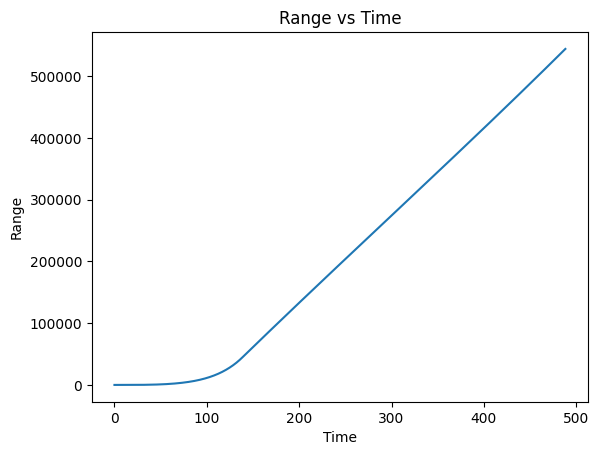

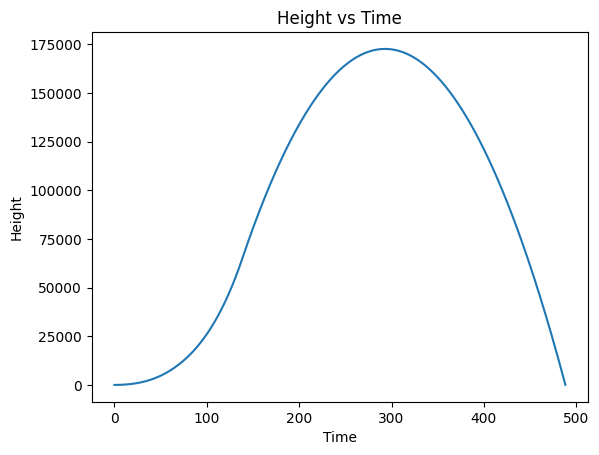

Data written to 'results/results_0.txt'


Stage 1 burnout
Velocity (km/s):  2.029740266780802
Angle (deg h):  43.65452989657996
Range (km):  44.15655351155459
Time (sec):  137.89999999999645
Final results: 
Range (km):  542.8727343412688
Apogee (km):  172.17612938591017
Time to target (sec):  487.3000000000423




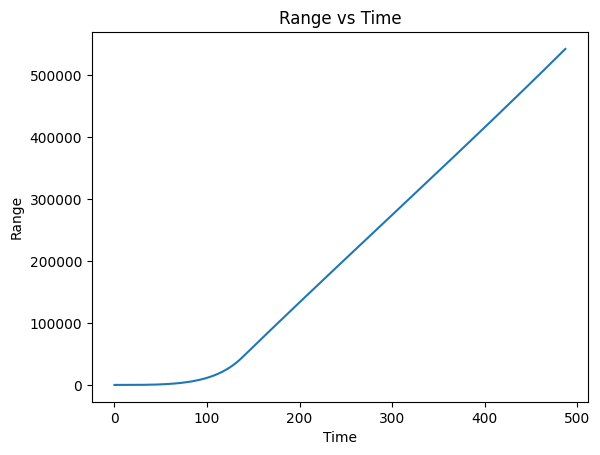

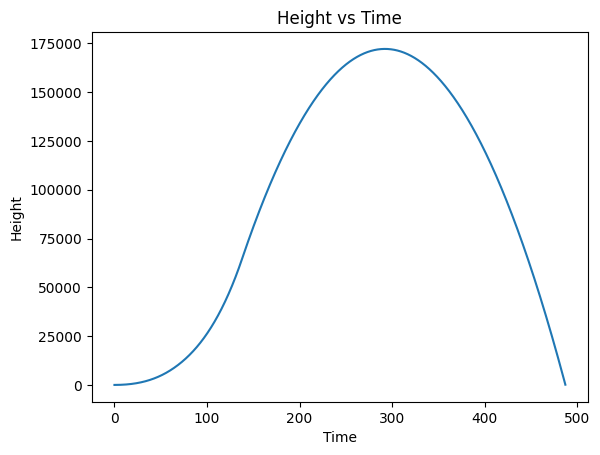

Data written to 'results/results_1.txt'


Stage 1 burnout
Velocity (km/s):  2.0427332968313188
Angle (deg h):  43.65693575680444
Range (km):  44.490021423363494
Time (sec):  137.39999999999648
Final results: 
Range (km):  549.7891161185148
Apogee (km):  174.2957740663086
Time to target (sec):  489.30000000004276




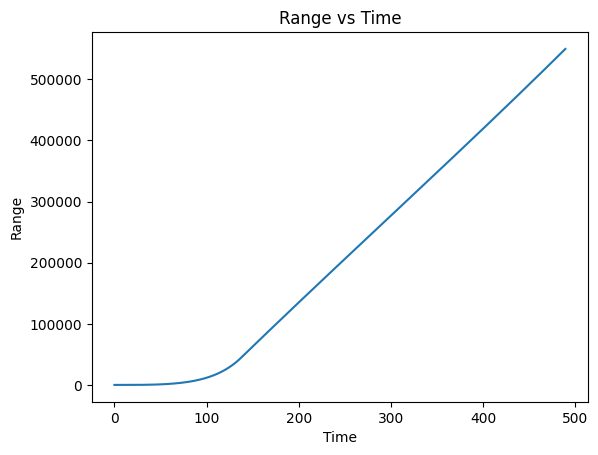

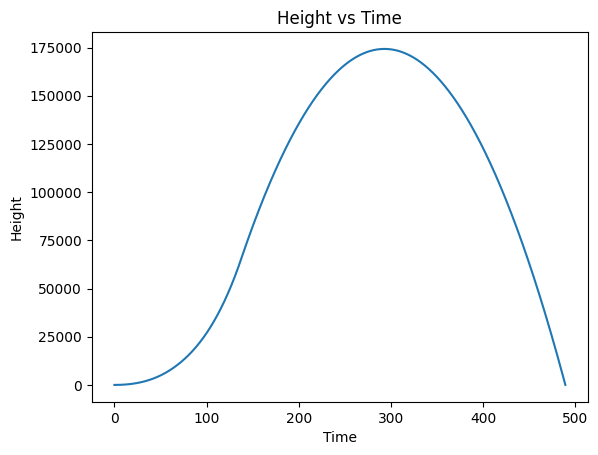

Data written to 'results/results_2.txt'


Stage 1 burnout
Velocity (km/s):  2.032158280580979
Angle (deg h):  43.65862422925817
Range (km):  44.15187204634154
Time (sec):  137.39999999999648
Final results: 
Range (km):  543.9674853846202
Apogee (km):  172.4977716583285
Time to target (sec):  487.2000000000423




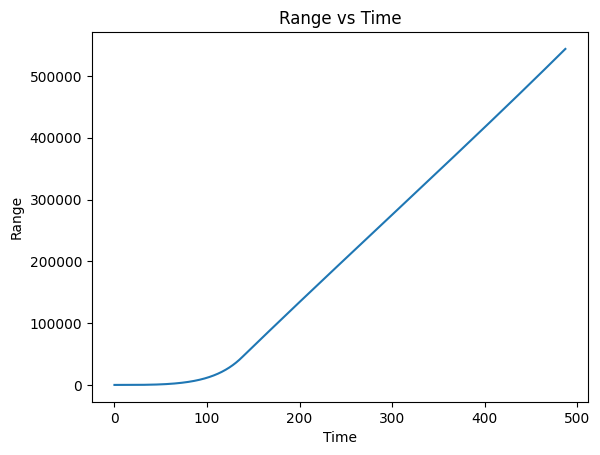

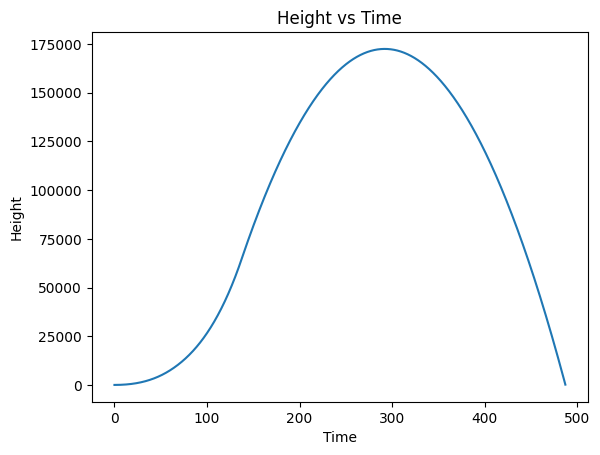

Data written to 'results/results_3.txt'


Stage 1 burnout
Velocity (km/s):  2.0541095013318262
Angle (deg h):  43.644907594760916
Range (km):  44.896132838469924
Time (sec):  137.89999999999645
Final results: 
Range (km):  555.8397745340768
Apogee (km):  176.07853007794398
Time to target (sec):  491.8000000000433




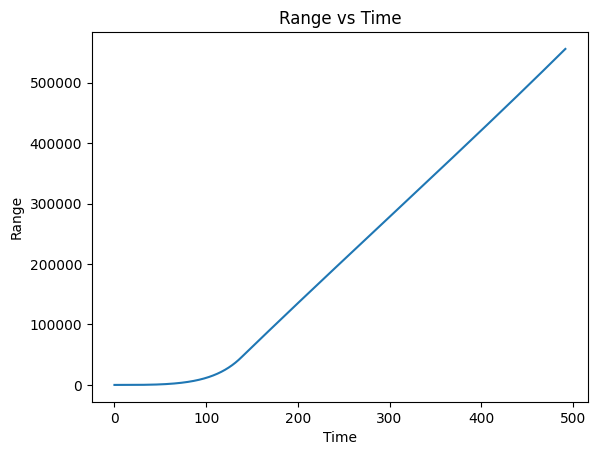

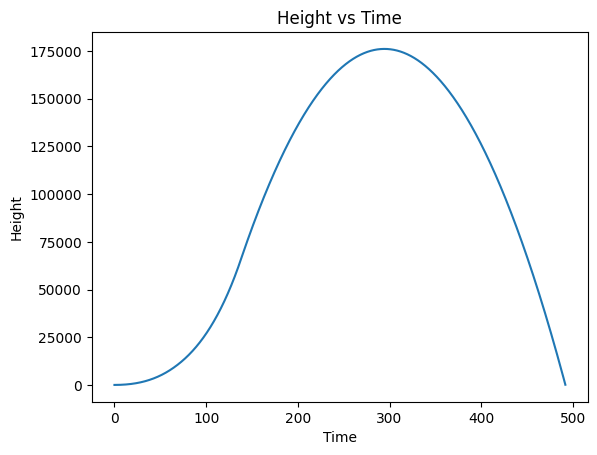

Data written to 'results/results_4.txt'


In [83]:
# Get true points (to build model)
wirte_output_txt = True
design = RandomDesign(space)
x = design.get_samples(5)
y = run_missile_sim(x)

In [24]:
# Build model
var_kernel = (100)**2 
lengthscale = 1 # 1
var_linear_kernel = (100)**2 
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
var_noise = 1e-5 # small value
# In catapult: 1e-5

kern = GPy.kern.RBF(input_dim=1, lengthscale=100, variance =var_kernel )  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
kern = GPy.kern.RBF(input_dim=1, lengthscale=100 ) + \
    GPy.kern.Linear(input_dim=1)

model_gpy = GPRegression(x,y, kernel=kern)
model_gpy.kern.variance =  var_kernel 
model_gpy.likelihood.variance.fix(var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(model_gpy)



GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,100.0,+ve,
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [25]:
# Fit emulator
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()



In [26]:
display(model_gpy)

GP_regression.,value,constraints,priors
sum.rbf.variance,2649.437300044844,+ve,
sum.rbf.lengthscale,2151.2851348834483,+ve,
sum.linear.variances,0.00791141883893402,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [15]:
# Get true points corresponding to param_1_x_plot (for plot)
wirte_output_txt = False
nr_points_plot = 301
param_1_x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, nr_points_plot)[:, None]
param_1_y_plot = run_missile_sim(param_1_x_plot)





Stage 1 burnout
Velocity (km/s):  0.4265056287972526
Angle (deg h):  43.732284489193205
Range (km):  0.9440400159604505
Time (sec):  12.299999999999974
Final results: 
Range (km):  21.661219962904816
Apogee (km):  6.737492515662497
Time to target (sec):  79.59999999999975


Data written to 'results/results_0.txt'


Stage 1 burnout
Velocity (km/s):  0.43905877485586203
Angle (deg h):  43.94232680213815
Range (km):  1.037682082180261
Time (sec):  12.799999999999972
Final results: 
Range (km):  23.013791615632808
Apogee (km):  7.19665589314658
Time to target (sec):  82.3999999999996


Data written to 'results/results_1.txt'


Stage 1 burnout
Velocity (km/s):  0.44799024767022866
Angle (deg h):  43.73993108354109
Range (km):  1.1013774296045882
Time (sec):  13.19999999999997
Final results: 
Range (km):  24.02034604907838
Apogee (km):  7.485179947127214
Time to target (sec):  84.0999999999995


Data written to 'results/results_2.txt'


Stage 1 burnout
Velocity (km/s):  0.46027208687599913

Data written to 'results/results_29.txt'


Stage 1 burnout
Velocity (km/s):  0.7202978297739892
Angle (deg h):  43.721497967193734
Range (km):  4.000609855124675
Time (sec):  25.9000000000001
Final results: 
Range (km):  64.18088861270505
Apogee (km):  20.309275138239624
Time to target (sec):  141.89999999999623


Data written to 'results/results_30.txt'


Stage 1 burnout
Velocity (km/s):  0.727200175156778
Angle (deg h):  43.66922481111436
Range (km):  4.095587026345635
Time (sec):  26.300000000000107
Final results: 
Range (km):  65.47851793270273
Apogee (km):  20.71032911508845
Time to target (sec):  143.39999999999614


Data written to 'results/results_31.txt'


Stage 1 burnout
Velocity (km/s):  0.7376295471833686
Angle (deg h):  43.72386243762432
Range (km):  4.244312578447072
Time (sec):  26.800000000000114
Final results: 
Range (km):  67.40006304156974
Apogee (km):  21.344939443798882
Time to target (sec):  145.699999999996


Data written to 'results/results_32.txt'


Stage 1 bur

Data written to 'results/results_57.txt'


Stage 1 burnout
Velocity (km/s):  0.9512920714418213
Angle (deg h):  43.74469408843027
Range (km):  7.773111429055287
Time (sec):  38.50000000000028
Final results: 
Range (km):  113.51926169943863
Apogee (km):  36.13512532946393
Time to target (sec):  193.2999999999933


Data written to 'results/results_58.txt'


Stage 1 burnout
Velocity (km/s):  0.9611011925015585
Angle (deg h):  43.67703295713308
Range (km):  7.955345648491317
Time (sec):  39.000000000000284
Final results: 
Range (km):  115.93695956104582
Apogee (km):  36.8196699320913
Time to target (sec):  195.2999999999932


Data written to 'results/results_59.txt'


Stage 1 burnout
Velocity (km/s):  0.967009648957825
Angle (deg h):  43.652338495464114
Range (km):  8.0690149758641
Time (sec):  39.40000000000029
Final results: 
Range (km):  117.4467022483384
Apogee (km):  37.288853263071104
Time to target (sec):  196.6999999999931


Data written to 'results/results_60.txt'


Stage 1 burnou

Final results: 
Range (km):  169.39903808691804
Apogee (km):  53.7981944904769
Time to target (sec):  240.39999999999063


Data written to 'results/results_85.txt'


Stage 1 burnout
Velocity (km/s):  1.1672797394362113
Angle (deg h):  43.656459986351436
Range (km):  12.247090102357344
Time (sec):  51.20000000000046
Final results: 
Range (km):  172.25860590871528
Apogee (km):  54.592948563059984
Time to target (sec):  242.3999999999905


Data written to 'results/results_86.txt'


Stage 1 burnout
Velocity (km/s):  1.172472664996571
Angle (deg h):  43.707469135347104
Range (km):  12.370655544371646
Time (sec):  51.60000000000046
Final results: 
Range (km):  173.7808073038043
Apogee (km):  55.181011134506484
Time to target (sec):  243.79999999999043


Data written to 'results/results_87.txt'


Stage 1 burnout
Velocity (km/s):  1.1819372876730345
Angle (deg h):  43.6590467235182
Range (km):  12.579403912765937
Time (sec):  52.10000000000047
Final results: 
Range (km):  176.67339701876622
Ap

Final results: 
Range (km):  231.524609210653
Apogee (km):  73.21002251930013
Time to target (sec):  285.59999999999644


Data written to 'results/results_112.txt'


Stage 1 burnout
Velocity (km/s):  1.3591656884941619
Angle (deg h):  43.645112674786354
Range (km):  16.928796145574488
Time (sec):  63.40000000000063
Final results: 
Range (km):  234.63391450051816
Apogee (km):  74.07771182967626
Time to target (sec):  287.4999999999969


Data written to 'results/results_113.txt'


Stage 1 burnout
Velocity (km/s):  1.3634430988816153
Angle (deg h):  43.68563833331169
Range (km):  17.056274215362418
Time (sec):  63.80000000000064
Final results: 
Range (km):  236.1539731468221
Apogee (km):  74.66442151243628
Time to target (sec):  288.79999999999717


Data written to 'results/results_114.txt'


Stage 1 burnout
Velocity (km/s):  1.3722716378343327
Angle (deg h):  43.647361196663134
Range (km):  17.282352259105977
Time (sec):  64.30000000000062
Final results: 
Range (km):  239.28040227606283


Final results: 
Range (km):  298.6870178643473
Apogee (km):  94.28526773777205
Time to target (sec):  330.2000000000066


Data written to 'results/results_141.txt'


Stage 1 burnout
Velocity (km/s):  1.5369182110328798
Angle (deg h):  43.639730146960595
Range (km):  22.17056484527043
Time (sec):  76.49999999999993
Final results: 
Range (km):  301.88114592635156
Apogee (km):  95.16669618460175
Time to target (sec):  332.000000000007


Data written to 'results/results_142.txt'


Stage 1 burnout
Velocity (km/s):  1.5400510591705938
Angle (deg h):  43.67290493780263
Range (km):  22.295151899849323
Time (sec):  76.8999999999999
Final results: 
Range (km):  303.1632094467732
Apogee (km):  95.70091818562662
Time to target (sec):  333.10000000000724


Data written to 'results/results_143.txt'


Stage 1 burnout
Velocity (km/s):  1.5478789857522226
Angle (deg h):  43.641637394674596
Range (km):  22.530665692146275
Time (sec):  77.39999999999988
Final results: 
Range (km):  306.365932848597
Apoge



Stage 1 burnout
Velocity (km/s):  1.6689040532026727
Angle (deg h):  43.66127451377329
Range (km):  26.82750631595337
Time (sec):  88.19999999999926
Final results: 
Range (km):  358.2243477057693
Apogee (km):  113.09109948856586
Time to target (sec):  367.90000000001515


Data written to 'results/results_168.txt'


Stage 1 burnout
Velocity (km/s):  1.6711467095962926
Angle (deg h):  43.65718998372942
Range (km):  26.94470168074167
Time (sec):  88.59999999999924
Final results: 
Range (km):  359.26341228595754
Apogee (km):  113.47423912092366
Time to target (sec):  368.70000000001534


Data written to 'results/results_169.txt'


Stage 1 burnout
Velocity (km/s):  1.6781606126689854
Angle (deg h):  43.662680719462315
Range (km):  27.181912415409663
Time (sec):  89.09999999999921
Final results: 
Range (km):  362.3601494182543
Apogee (km):  114.4221983133505
Time to target (sec):  370.50000000001575


Data written to 'results/results_170.txt'


Stage 1 burnout
Velocity (km/s):  1.680340726

Final results: 
Range (km):  410.2924143196262
Apogee (km):  129.78125803728392
Time to target (sec):  400.6000000000226


Data written to 'results/results_194.txt'


Stage 1 burnout
Velocity (km/s):  1.7867376586864454
Angle (deg h):  43.6537107608242
Range (km):  31.594760504684878
Time (sec):  100.39999999999857
Final results: 
Range (km):  413.37219901644056
Apogee (km):  130.6194974645973
Time to target (sec):  402.20000000002295


Data written to 'results/results_195.txt'


Stage 1 burnout
Velocity (km/s):  1.7882112767272529
Angle (deg h):  43.65140749759764
Range (km):  31.700863134337204
Time (sec):  100.79999999999855
Final results: 
Range (km):  414.1696781178146
Apogee (km):  130.9280695541935
Time to target (sec):  402.9000000000231


Data written to 'results/results_196.txt'


Stage 1 burnout
Velocity (km/s):  1.794524701941269
Angle (deg h):  43.655006990743566
Range (km):  31.93513965002722
Time (sec):  101.29999999999852
Final results: 
Range (km):  417.1970933485121
A



Stage 1 burnout
Velocity (km/s):  1.892337500254363
Angle (deg h):  43.64901880604165
Range (km):  36.45352243898193
Time (sec):  113.49999999999783
Final results: 
Range (km):  466.8246496552403
Apogee (km):  147.688899399986
Time to target (sec):  435.60000000003055


Data written to 'results/results_224.txt'


Stage 1 burnout
Velocity (km/s):  1.893072579246318
Angle (deg h):  43.670868588461275
Range (km):  36.544783359996636
Time (sec):  113.8999999999978
Final results: 
Range (km):  467.3077023930241
Apogee (km):  147.98386977220406
Time to target (sec):  436.3000000000307


Data written to 'results/results_225.txt'


Stage 1 burnout
Velocity (km/s):  1.8987190886252991
Angle (deg h):  43.65019469983469
Range (km):  36.77150311506025
Time (sec):  114.39999999999777
Final results: 
Range (km):  470.11535141762107
Apogee (km):  148.77410080667465
Time to target (sec):  437.700000000031


Data written to 'results/results_226.txt'


Stage 1 burnout
Velocity (km/s):  1.8994086514568



Stage 1 burnout
Velocity (km/s):  1.9738101265332688
Angle (deg h):  43.64419637725708
Range (km):  40.656897968798454
Time (sec):  125.69999999999713
Final results: 
Range (km):  510.67507083504205
Apogee (km):  161.73528175597698
Time to target (sec):  463.70000000003694


Data written to 'results/results_251.txt'


Stage 1 burnout
Velocity (km/s):  1.973956619995361
Angle (deg h):  43.66386139427188
Range (km):  40.73220618029986
Time (sec):  126.09999999999711
Final results: 
Range (km):  510.896111847987
Apogee (km):  161.93979176149992
Time to target (sec):  464.3000000000371


Data written to 'results/results_252.txt'


Stage 1 burnout
Velocity (km/s):  1.979067201270783
Angle (deg h):  43.64528657945813
Range (km):  40.94859322640171
Time (sec):  126.59999999999708
Final results: 
Range (km):  513.6737908456354
Apogee (km):  162.6800916797515
Time to target (sec):  465.7000000000374


Data written to 'results/results_253.txt'


Stage 1 burnout
Velocity (km/s):  1.979165089306

Final results: 
Range (km):  548.5617069198099
Apogee (km):  173.9424144808009
Time to target (sec):  489.70000000004285


Data written to 'results/results_279.txt'


Stage 1 burnout
Velocity (km/s):  2.045041295819789
Angle (deg h):  43.641225187636906
Range (km):  44.739639490741155
Time (sec):  138.7999999999964
Final results: 
Range (km):  551.1427418066775
Apogee (km):  174.6251941017791
Time to target (sec):  491.00000000004314


Data written to 'results/results_280.txt'


Stage 1 burnout
Velocity (km/s):  2.0446199029197434
Angle (deg h):  43.658977824909734
Range (km):  44.79589442265172
Time (sec):  139.19999999999638
Final results: 
Range (km):  551.083972154244
Apogee (km):  174.7291286589076
Time to target (sec):  491.50000000004326


Data written to 'results/results_281.txt'


Stage 1 burnout
Velocity (km/s):  2.0492036829415374
Angle (deg h):  43.642224962432536
Range (km):  44.998019595551426
Time (sec):  139.69999999999635
Final results: 
Range (km):  553.6587851104707


In [16]:
# Get model prediction on param_1_x_plot
mu_plot, var_plot = model_emukit.predict(param_1_x_plot)



In [27]:
# Plot
def helper_plot_emulator_errorbars(x_plot, y_plot, mu_plot, var_plot, model_emukit):
    """Helper function for plotting the emulator fit."""
    ax.plot(model_emukit.X[:, 0], model_emukit.Y, 'ro', markersize=10, label='observations')
    ax.plot(x_plot[:, 0], mu_plot, 'C0', label='model', linewidth=3)
    ax.plot(x_plot[:, 0], y_plot, 'k', label='target function', linewidth=2)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel(custom_param_names[0])
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    #ax.set_xlim(-0.01, 1)
    #ax.set_ylim([-20, 20])
    

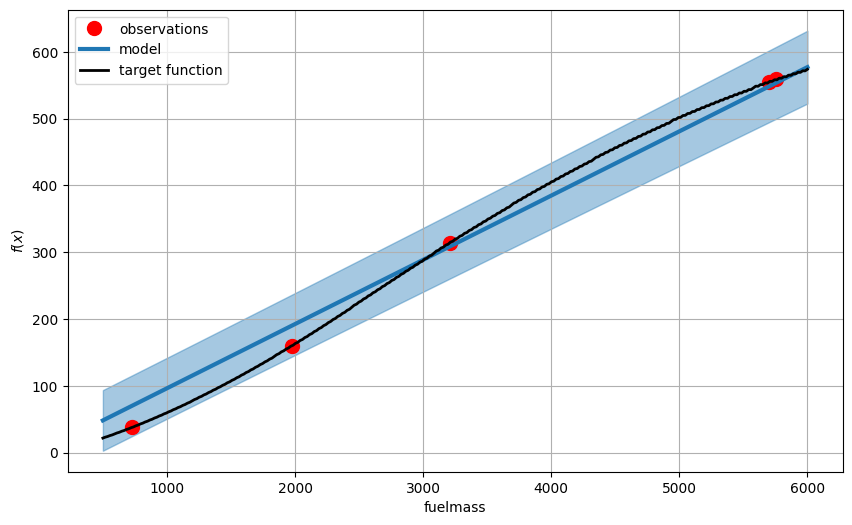

In [28]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=param_1_x_plot, y_plot=param_1_y_plot, 
                               mu_plot=mu_plot, var_plot=var_plot, 
                               model_emukit=model_emukit)

# 1. Two params

In [78]:
param_1 = 'fuelmass'
domain_param_1 = [5550, 5650] # [5000,15000]
param_2 = 'Isp0'
domain_param_2 = [224, 228]

space = ParameterSpace(
          [ContinuousParameter(param_1, *domain_param_1), 
           ContinuousParameter(param_2, *domain_param_2),
#            ContinuousParameter(param_3, *domain_param_3),
#            ContinuousParameter(param_4, *domain_param_4)
          ])

custom_param_names = [param_1, param_2]

In [84]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


## Experimental design


New simulation 

fuelmass: 5587.141992135764
Isp0: 227.2091124855569


Stage 1 burnout
Velocity (km/s):  2.052424515086459
Angle (deg h):  43.64084308802592
Range (km):  44.9130403869612
Time (sec):  138.39999999999642
Final results: 
Range (km):  555.0649204692008
Apogee (km):  175.81398184288815
Time to target (sec):  492.00000000004337




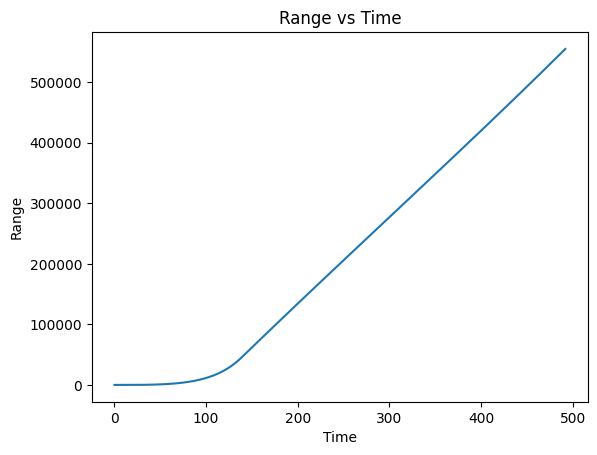

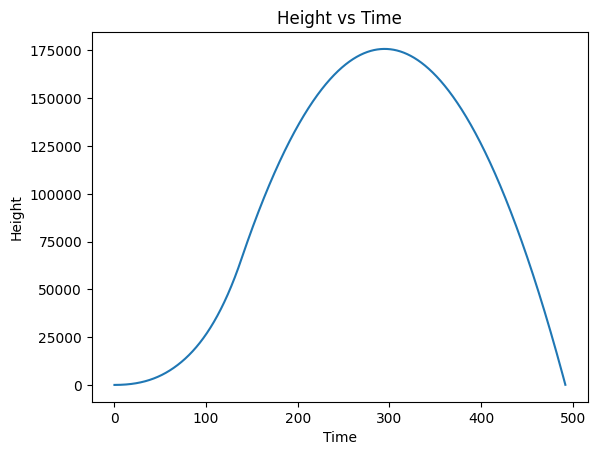

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 5558.227132952292
Isp0: 226.72879676437398


Stage 1 burnout
Velocity (km/s):  2.0390924504606156
Angle (deg h):  43.65665060020926
Range (km):  44.36259647183954
Time (sec):  137.2999999999965
Final results: 
Range (km):  547.8121368523597
Apogee (km):  173.68127278134327
Time to target (sec):  488.5000000000426




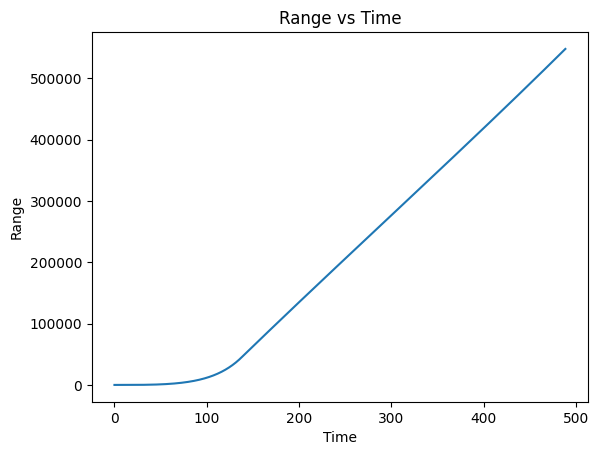

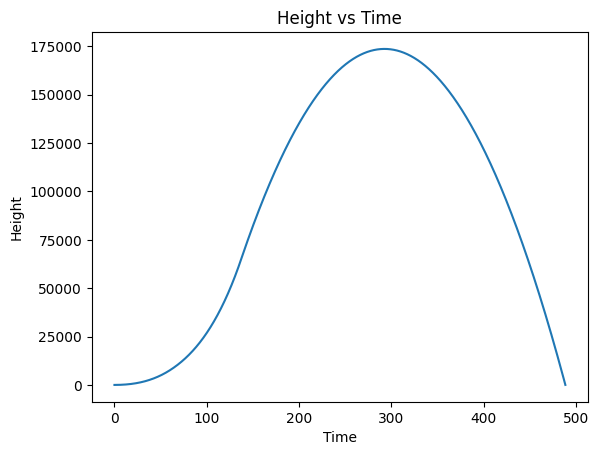

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 5647.201595984135
Isp0: 225.05965025293756


Stage 1 burnout
Velocity (km/s):  2.0335011656736213
Angle (deg h):  43.662959794152634
Range (km):  44.352541543182234
Time (sec):  138.49999999999642
Final results: 
Range (km):  545.0109523243451
Apogee (km):  172.85338266779286
Time to target (sec):  488.7000000000426




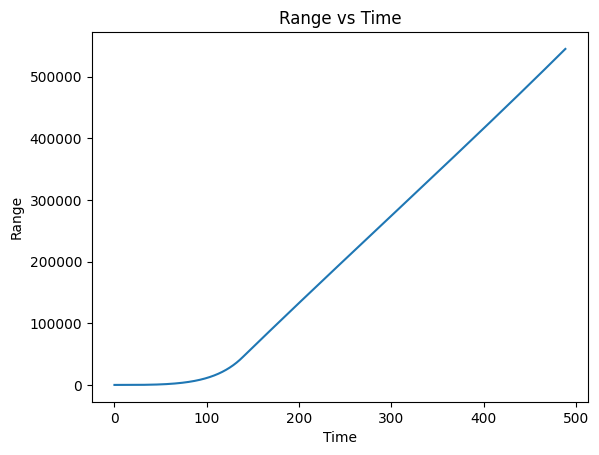

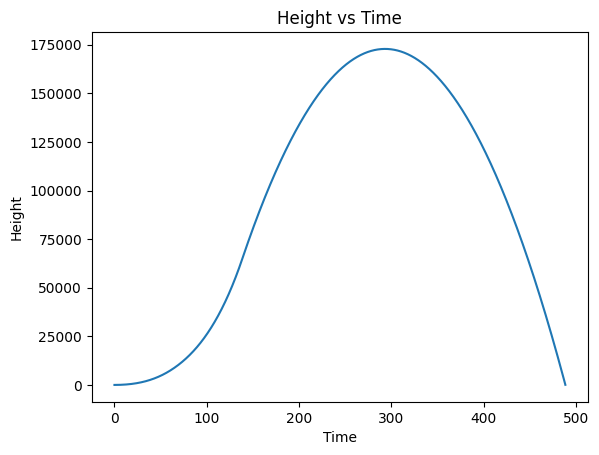

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 5591.353874714678
Isp0: 224.4935550399626


Stage 1 burnout
Velocity (km/s):  2.0215992031001244
Angle (deg h):  43.65813977401053
Range (km):  43.73939416340099
Time (sec):  136.79999999999652
Final results: 
Range (km):  538.2696473294301
Apogee (km):  170.70165124460416
Time to target (sec):  484.6000000000417




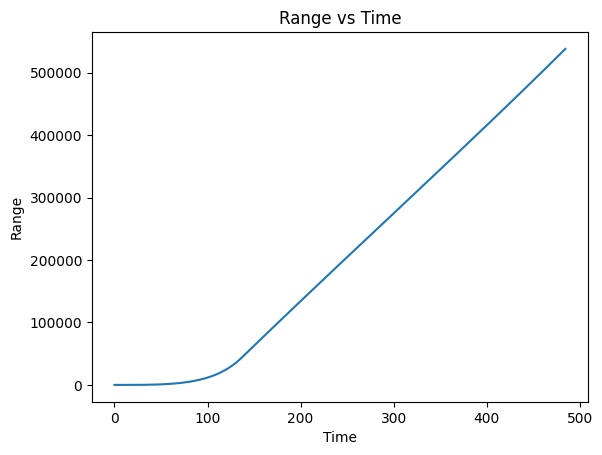

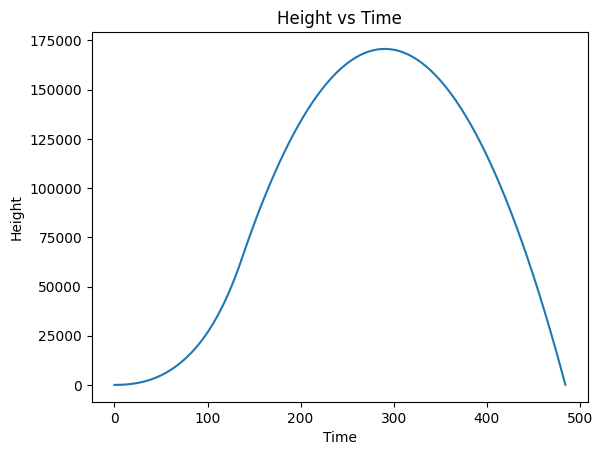

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 5621.235838786767
Isp0: 226.26851636414438


Stage 1 burnout
Velocity (km/s):  2.0431160518083638
Angle (deg h):  43.664313534247825
Range (km):  44.66762289375858
Time (sec):  138.5999999999964
Final results: 
Range (km):  550.1273258366667
Apogee (km):  174.46600432909472
Time to target (sec):  490.60000000004305




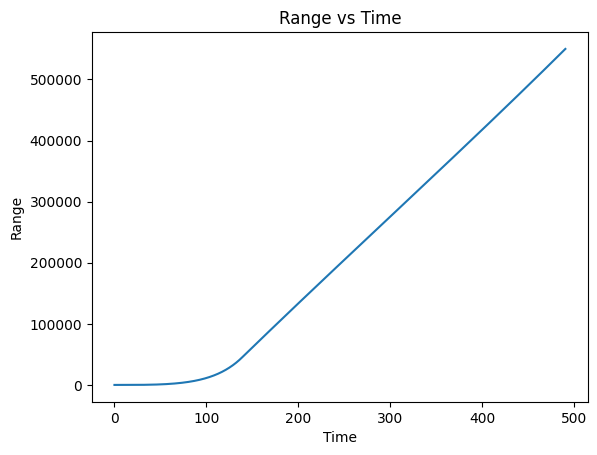

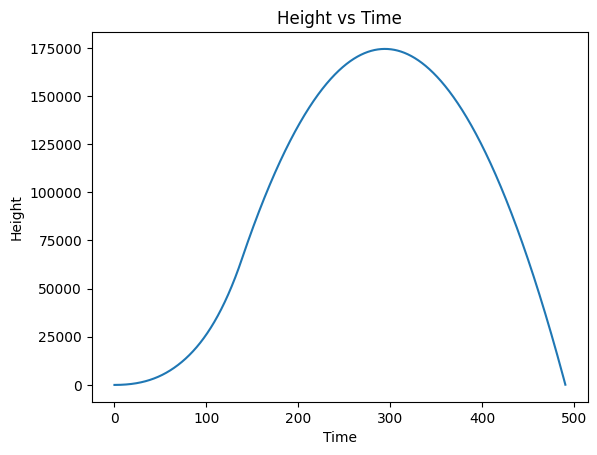

Data written to 'results/results_4.txt'


In [85]:
wirte_output_txt = True
design = RandomDesign(space)
x = design.get_samples(5)
y = run_missile_sim(x)

In [33]:
# Build model
var_kernel = (100)**2 
lengthscale = 1 # 1
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
var_noise = 1e-5 # small value
# In catapult: 1e-5

kern = GPy.kern.RBF(input_dim=2, lengthscale=lengthscale, variance =var_kernel)  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
# kern = GPy.kern.RBF(input_dim=1, lengthscale=100 ) + \
#     GPy.kern.Linear(input_dim=1)

model_gpy = GPRegression(x,y, kernel=kern)
model_gpy.kern.variance =  var_kernel 
model_gpy.likelihood.variance.fix(var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(model_gpy)




GP_regression.,value,constraints,priors
rbf.variance,10000.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [34]:
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

In [35]:
display(model_gpy)

GP_regression.,value,constraints,priors
rbf.variance,4954559.2128214,+ve,
rbf.lengthscale,670.6731548568795,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [ ]:
x_plot = np.array([])
y_plot = run_missile_sim(x_plot)
mu_plot, var_plot = model_emukit.predict(x_plot)
# mu_plot

In [ ]:
def helper_plot_emulator_errorbars(x_plot, y_plot, mu_plot, var_plot, model_emukit):
    """Helper function for plotting the emulator fit."""
    ax.plot(model_emukit.X[:, 0], model_emukit.Y, 'ro', markersize=10, label='observations')
    ax.plot(x_plot[:, 0], mu_plot, 'C0', label='model', linewidth=3)
    ax.plot(x_plot[:, 0], y_plot, 'k', label='target function', linewidth=2)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel(custom_param_names[0])
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    #ax.set_xlim(-0.01, 1)
    #ax.set_ylim([-20, 20])
    

In [93]:
mu_plot.shape

(121, 1)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11, 11) and arg 2 with shape (121, 1).

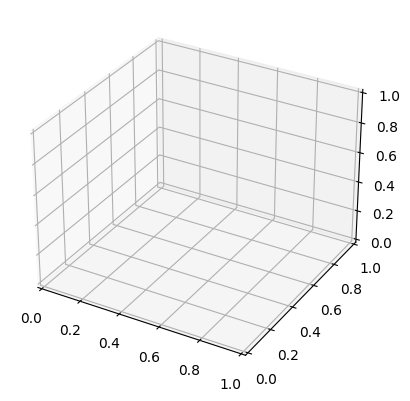

In [97]:
fig = plt.figure()
# fig.figsize = fig_size
#ax = fig.gca(projection='3d') # projection='3d'
ax = fig.add_subplot(projection='3d')

wirte_output_txt = False
nr_points_plot = 11
param_1_x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, nr_points_plot)[:, None]
param_2_x_plot = np.linspace(space.parameters[1].min, space.parameters[1].max, nr_points_plot)[:, None]
x_plot_mesh, y_plot_mesh = np.meshgrid(param_1_x_plot, param_2_x_plot)
x_plot = np.array([x_plot_mesh, y_plot_mesh]).T.reshape(-1,2)
# Z = run_missile_sim(x_plot)

mu_plot, var_plot = model_emukit.predict(x_plot)

surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, Z, 
                       alpha = 1, 
                       #rstride=1, cstride=1, cmap=cm.winter, linewidth=0.5, antialiased=True
                       label='target function',
                      )
surf = ax.plot_surface(param_1_x_plot, param_2_x_plot, mu_plot, 
                       alpha = 1, 
                       #rstride=1, cstride=1, cmap=cm.autumn,linewidth=0.5, antialiased=True,
                       label='model'
                      )



In [ ]:
model_emukit.Y

In [ ]:
x_plot

In [ ]:
import matplotlib.pyplot as plt
import mlai.plot as plot

# x_plot = x
# y_plot = y
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=x_plot, y_plot=y_plot, 
                               mu_plot=mu_plot, var_plot=var_plot, 
                               model_emukit=model_emukit, index=0)

In [ ]:
# x_plot = x
# y_plot = y
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=x_plot, y_plot=y_plot, 
                               mu_plot=mu_plot, var_plot=var_plot, 
                               model_emukit=model_emukit, index=1)


In [ ]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [ ]:
help(ExperimentalDesignLoop)

In [ ]:
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition = integrated_variance)
ed.run_loop(user_function=run_missile_sim, stopping_condition=10)


## Sensitivity Analysis

In [ ]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [ ]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [ ]:
import pandas as pd


In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='first-order-sobol-indices-gp-catapult.svg', directory='./uq')


In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='total-effects-sobol-indices-gp-catapult.svg', directory='./uq')